In [2]:
from termcolor import cprint
from tqdm import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser
from ml_logger import logger
from plan2vec_experiments import RUN

# Inspecting the Inter-connectivity in the Rope Dataset

First load the pre-computed pair-wise score from the map-reduced chunks on the cluster:
 
Use the `chunk_prefix` below:

In [3]:
# np.save(arr=ds, file=expanduser("~/pairwise.npy"))
ds = np.load(file=expanduser("~/pairwise.npy"))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ge/pairwise.npy'

In [ ]:
chunk_prefix = "episodeyang/plan2vec/2019/04-24/analysis_rope/run-13.42.11"
n = 20

logger.configure(RUN.server, register_experiment=False)

path = f"/{chunk_prefix}"
ds = np.concatenate([logger.load_pkl(path + f"/chunk_{k:02d}.pkl")[0] for k in trange(n, desc="load")])

In [ ]:
rope = np.load(expanduser("~/fair/new_rope_dataset/data/new_rope.npy"))
all_images = np.concatenate(rope).transpose(0, 3, 1, 2)
traj_labels = np.concatenate([np.ones(len(traj)) * i for i, traj in enumerate(rope)]).astype(int)

assert len(all_images) == len(ds), "the dimension of the distance matrix and the images should agree."
cprint('rope dataset is now loaded', "yellow")

In [ ]:
logger.configure(prefix="plan2vec_experiments/rope", register_experiment=False)

In [ ]:
i = 6
fig = plt.figure(figsize=(6, 2.8))
_ = all_images[i, 0]
plt.subplot(121)
plt.imshow(_, cmap="gray")
plt.subplot(122)
plt.title('Score Distribution')
plt.hist(ds[i], histtype='step', linewidth=4, alpha=0.4, color='#23aaff', label=f"img #{i}", density=True)
plt.hist(ds.flatten(), histtype='step', linewidth=4, alpha=0.4, color='red', label=" all ", density=True)
# plt.yscale('log', nonposy='clip')
plt.legend(loc=(0, 0.7), frameon=False, framealpha=1)
plt.ylim(0, .05)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
logger.savefig(f"figures/score_distribution.png")

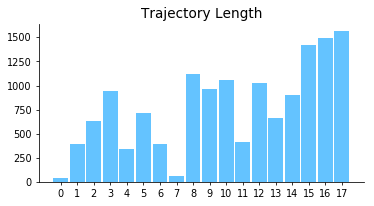

In [8]:
fig = plt.figure(figsize=(6, 3), dpi=70)
plt.title('Trajectory Length', fontsize=14)
plt.hist(traj_labels, bins=np.arange(-0.5, 18.5, 1), rwidth=0.9, color="#23aaff", alpha=0.7)
plt.xticks(np.arange(18), range(18))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(logger.log_directory + f"/figures/trajectory_length.png")

For each of the trajectories, we can show a tuple (in_traj, out_traj) on top
(as inset). For the first one for example. we can print the list of trajectory
labels that the neighbors include.

In [9]:
import torch

i = 6000

print(f"sample is in traj #{traj_labels[i]}")
top, top_inds = torch.topk(torch.tensor(ds[i]), 24, largest=False, sorted=True)
neighbor_traj_lables = traj_labels[top_inds]
traj_inds = set(neighbor_traj_lables) - {traj_labels[i]}
print(f"neighbors come from {traj_inds}")

sample is in traj #10
neighbors come from {11}


'plan2vec_experiments/rope/figures/neighbors_traj-10_006000.png'

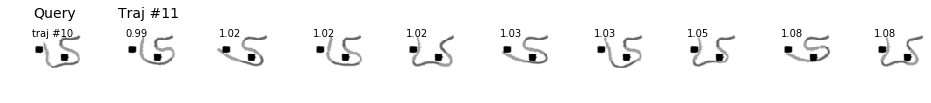

In [10]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 1.4 * len(traj_inds)))
gs = GridSpec(len(traj_inds), 10)
for row_i, traj_ind in enumerate(traj_inds):
    gs_i = 0
    plt.subplot(gs[row_i, gs_i])
    plt.axis('off')
    plt.title(f"Query", fontsize=14)
    plt.text(5, 14, f"traj #{traj_labels[i]}")
    plt.imshow(all_images[i][0], cmap="gray")
    for label, score, ind in zip(neighbor_traj_lables, top, top_inds):
        if label != traj_ind:
            continue
        gs_i += 1
        plt.subplot(gs[row_i, gs_i])
        plt.axis('off')
        if gs_i == 1:
            plt.title(f'Traj #{traj_labels[ind]}', fontsize=14)
        plt.text(5, 14, f"{score:0.2f}")
        plt.imshow(all_images[ind][0], cmap="gray")
fig.tight_layout(h_pad=-1, w_pad=-5)
logger.savefig(f"figures/neighbors_traj-{traj_labels[i]:02d}_{i:06d}.png")

single image that has 12 neighboring trajectories:  8367


(-0.5, 63.5, 63.5, -0.5)

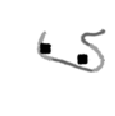

In [11]:
top_cols, top_col_inds = torch.topk(torch.tensor(ds), k=24, dim=1, largest=False, sorted=True)
_ = np.array([len(set(row)) for row in traj_labels[top_col_inds]])
print("single image that has 12 neighboring trajectories: ", np.argmax(_==12))
plt.figure(figsize=(1.5, 1.5))
plt.imshow(all_images[_==12][0, 0], cmap="gray")
plt.axis('off')

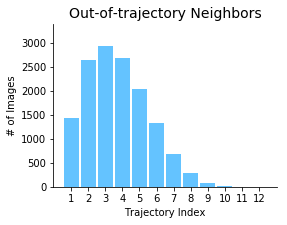

In [12]:
_ = np.array([len(set(row)) for row in traj_labels[top_col_inds]])
bins = np.arange(1, _.max() + 2, dtype=np.uint8)
plt.figure(figsize=(4, 3))
plt.title("Out-of-trajectory Neighbors", fontsize=14)
plt.hist(_, bins=bins, rwidth=0.9, color="#23aaff", alpha=0.7)
plt.xlabel('Trajectory Index')
plt.ylabel('# of Images')
plt.xticks(bins[:-1] + 0.5, bins[:-1])
plt.ylim(0, 3400)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(logger.log_directory + f"/figures/traj_distribution.png")

### How many other trajectories are connected?

In this cell we pick a single trajectory, then iterate through each image inside this trajectory,
and find the union of the sets of out-of-traj neighbor's trajectory label for each image. 

In [13]:
s = None 
for labels in traj_labels[top_col_inds]:
    _ = {*labels}
    s = s if s else {*labels}
    n = s.intersection(_)
    s.update(_ if n else None)
print(s)
print("total items in set is:", len(s))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
total items in set is: 18


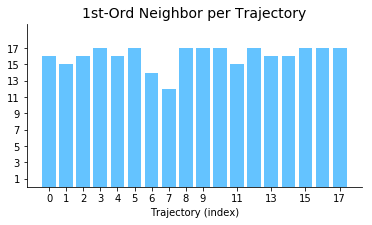

In [14]:
from collections import defaultdict
s = defaultdict(set)
for _, labels in zip(traj_labels, traj_labels[top_col_inds]):
    s[_].update(set(labels) - set([_]))

plt.figure(figsize=(6, 3))
plt.title("1st-Ord Neighbor per Trajectory", fontsize=14)
plt.bar(range(18), [len(s[_]) for _ in range(18)], color="#23aaff", alpha=0.7)
plt.xlabel('Trajectory (index)')
plt.ylim(0, 20)
plt.yticks(range(1, 19, 2))
plt.xticks([*range(10), *range(11, 18, 2)])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(logger.log_directory + f"/figures/1st-ord_neighbors_per_traj.png")

## Picking **One** trajectory to work with

### Adjacency Matrix (trajectory level)

First let's take a look at how the trajectories are interconnected.

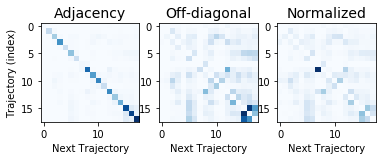

In [31]:
# two plots: full adjacency matrix + sans the diagonal terms
m = defaultdict(lambda: 0)
for self_label, next_labels in zip(traj_labels, traj_labels[top_col_inds]):
    for next_label in next_labels:
        m[self_label, next_label] += 1
m = np.array([[m[_i, _j]  for _j in range(18)] for _i in range(18)])
plt.figure(figsize=(6, 3))
plt.subplot(131)
plt.title("Adjacency", fontsize=14)
plt.imshow(m, cmap="Blues")
plt.xlabel('Next Trajectory')
plt.ylabel('Trajectory (index)')
plt.subplot(132)
plt.title('Off-diagonal', fontsize=14)
m[np.eye(18) == 1] = 0
plt.imshow(m, cmap="Blues")
plt.xlabel('Next Trajectory')
plt.subplot(133)
plt.title('Normalized', fontsize=14)
_m= m.copy()
_m[np.eye(18) == 1] = 0
plt.imshow(_m / m.sum(axis=-1), cmap="Blues")
plt.xlabel('Next Trajectory')
plt.savefig("figures/trajectory_adjacency.png", dpi=300, bbox_inches="tight")
fig.show();

## Pick the 8th trajectory
The overall index is

In [65]:
f"[{np.argmax(traj_labels == 8)}, {np.argmax(traj_labels == 9)})"

'[3514, 4638)'

visualize the trajectory number 8: Let's take a look at what's inside!

In [34]:
len(rope)
rope[8].shape

(1124, 64, 64, 1)

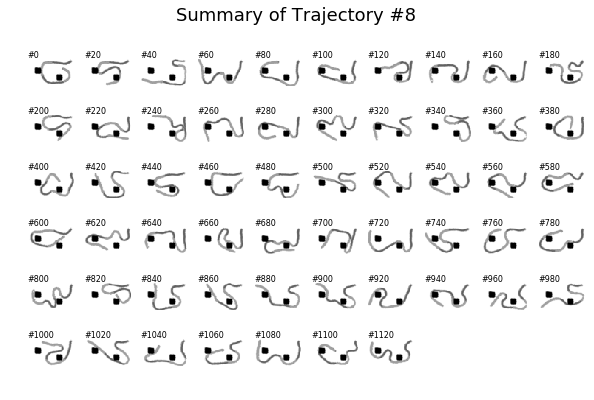

In [54]:
picked = rope[8][::20].squeeze(axis=-1)
fig = plt.figure(figsize=np.array(1.4, dtype=int) * [10, 6])
plt.suptitle('Summary of Trajectory #8', fontsize=18)
gs = GridSpec(6, 10)
index = 0
for _row in range(6):
    for _col in range(10):
        plt.subplot(gs[_row, _col])
        try:
            plt.imshow(picked[index] , cmap='gray')
            plt.text(0, 10, f"#{index * 20}", fontsize=8)
        except:
            pass
        plt.axis('off')
        index += 1
        
plt.savefig("figures/traj-8.png", dpi=300, bbox_inches="tight")
plt.show()

We can do this for all trajectories (subsample by 20, and save in a grid)

In [59]:
from math import ceil

for traj_ind in trange(18):
    picked = rope[traj_ind][::20].squeeze(axis=-1)
    n_rows = ceil(len(picked) / 10)
    fig = plt.figure(figsize=np.array(1.4, dtype=int) * [10, n_rows])
    plt.suptitle(f'Summary of Trajectory #{traj_ind}', fontsize=14)
    gs = GridSpec(n_rows, 10)
    index = 0
    for _row in range(n_rows):
        for _col in range(10):
            plt.subplot(gs[_row, _col])
            try:
                plt.imshow(picked[index] , cmap='gray')
                plt.text(0, 10, f"#{index * 20}", fontsize=8)
            except:
                pass
            plt.axis('off')
            index += 1
            
    logger.savefig(f"figures/traj summary/traj-{traj_ind:02d}.png", dpi=300, bbox_inches="tight")
    plt.close()

100%|██████████| 18/18 [00:40<00:00,  3.59s/it]


In [ ]:
# np.save(arr=ds, file=expanduser("~/pairwise.npy"))

In [137]:
a.size



200109316